# Read image

In [ ]:
from matplotlib import pyplot as plt

from utils import imshow

In [ ]:
image = plt.imread("Lenna.png")
imshow(image)

# Grayscale Channels and Histograms

In [ ]:
def Grayscale(img):
    return (
          0.2125 * img[..., 0]
        + 0.7154 * img[..., 1]
        + 0.0721 * img[..., 2]
    )


def Red(img):
    return img[:, :, 0]


def Green(img):
    return img[:, :, 1]


def Blue(img):
    return img[:, :, 2]

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from utils import imshow

image = plt.imread('Lenna.png')
plt.figure(figsize=(10, 10))
for row, f in enumerate([Grayscale, Red, Green, Blue]):
    plt.subplot(4, 2, 2*row+1)
    plt.title(f.__name__)
    imshow(f(image))
    plt.subplot(4, 2, 2*row+2)
    sns.histplot(np.ravel(f(image)), stat='probability',
                 binrange=(0, 1), bins=64)

plt.tight_layout()

In [ ]:
from typing import Counter


def hist(image: np.ndarray, n_bins: int, min_=0, max_=1) -> list[float]:
    array = np.floor((image.flatten() - min_) / (max_-min_) * n_bins)
    counts = Counter(array)
    counts[n_bins-1] += counts[n_bins]
    return [counts[i] for i in range(n_bins)]


assert np.all(hist(image, 4) == np.histogram(image, 4, (0, 1))[0])
sns.barplot(hist(Grayscale(image), 16))
plt.tight_layout()

# Widow Stats

In [ ]:
import cv2
import numpy as np

In [ ]:
def show_zoomed(image, size=11, zoom=20):
    zoomed = cv2.resize(image, (size * zoom, size * zoom), 
                        interpolation=cv2.INTER_NEAREST)

    color = (100, 100, 100)
    for i in range(1, size):
        cv2.line(zoomed, (i * zoom, 0), (i * zoom, size * zoom), color, 1)
        cv2.line(zoomed, (0, i * zoom), (size * zoom, i * zoom), color, 1)
    
    cv2.imshow('zoomed', zoomed)

In [ ]:
def show_stats(image, point):
    x, y = point
    size = image.shape[0]
    half = size // 2
    b, g, r = image[half, half]
    intensity = np.mean((r, g, b))
    mean_w = np.mean(image)
    std_w = np.std(image)
    info_img = np.ones((200, 500, 3), dtype=np.uint8) * 255
    cv2.putText(info_img, f"Coordinates: ({x}, {y})", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(info_img, f"RGB: R={r}, G={g}, B={b}", (10, 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(info_img, f"Intensity: {intensity:.2f}", (10, 90), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(info_img, f"Window Mean: {mean_w:.2f}", (10, 120), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(info_img, f"Window Std: {std_w:.2f}", (10, 150), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.imshow('Stats', info_img)

In [ ]:
def draw_border(image, x, y, size=11):
    half = size // 2

    cv2.rectangle(
        img=image, 
        pt1=(x-half-1, y-half-1), 
        pt2=(x+half+1, y+half+1), 
        color=(0, 0, 0), 
        thickness=1
        )
    return image


def mouse_callback(event, x, y, flags, params, size=11):
    image, out_image = params
    half = size // 2
    height, width = image.shape[:2]
    if not half <= x < width-half:
        return
    if not half <= y < height-half:
        return
    
    out_image[:,:,:] = image[:,:,:]
    draw_border(out_image, x, y, size)
    
    window = image[y-half:y+half+1, x-half:x+half+1]
    
    show_zoomed(window)
    show_stats(window, (x, y))
    

    
image = cv2.imread("Lenna.png")
out_image = image.copy()

window = 'Oleg'
cv2.imshow(window, out_image)
cv2.setMouseCallback(window, mouse_callback, [image, out_image])
while True:
    if cv2.waitKey(1) == ord('q'):
        break
    cv2.imshow(window, out_image)
cv2.destroyAllWindows()

# Editor

## Code

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from utils import imshow

In [ ]:
np_image = plt.imread('Lenna.png')
imshow(np_image)

In [ ]:
from functools import wraps
from typing import Callable

def blend(old: np.ndarray, new: np.ndarray, new_old_ratio: float) -> np.ndarray:
    return new * new_old_ratio + old * (1-new_old_ratio)


def blend_decor(func: Callable):
    @wraps(func)
    def inner(image: np.ndarray, ratio: float, *args, **kwargs) -> np.ndarray:
        new = func(image, *args, **kwargs)
        return blend(image, new, ratio)
    return inner

In [ ]:
from typing import Optional


def gamma_correction(
    P_in: np.ndarray,
    gamma: float,
    chanel: Optional[int] = None,
) -> np.ndarray:
    if chanel is None:
        A = 1
        return (A*P_in)**gamma
    new = P_in.copy()
    new[..., chanel] = gamma_correction(new[..., chanel], gamma)
    return new

x = np.linspace(0, 1, 1000)
data = pd.DataFrame({
    f"$\\gamma = {gamma}$": gamma_correction(x, gamma)
    for gamma in (0.3, 0.5, 1, 2)
}, index=x)
sns.lineplot(data)
None

In [ ]:
@blend_decor
def sigmoid(
    P_in: np.ndarray,
    gamma: float,
) -> np.ndarray:
    return 1 / ( 1 + np.exp(gamma * (0.5 - P_in)) )

x = np.linspace(0, 1)
data = pd.DataFrame({
    f"$\\gamma = {gamma}$": sigmoid(x, 1, gamma)
    for gamma in (1, 7, 10, 30)
}, index=x)
sns.lineplot(data)
None

In [ ]:
def invert(image: np.ndarray, channels: list[int]) -> np.ndarray:
    image = image.copy()
    image[..., channels] = 1 - image[..., channels]
    return image

In [ ]:
def flip(image: np.ndarray, axis: set[int]) -> np.ndarray:
    image = image.copy()
    if 0 in axis:
        image = image[-1:0:-1, ...]
    if 1 in axis:
        image = image[:, -1:0:-1, :]
    return image

In [ ]:
def swap(image: np.ndarray, colors: tuple[int, int, int]) -> np.ndarray:
    return image[..., colors]

In [ ]:
def overflow(image: np.ndarray, mul: float) -> np.ndarray:
    return (image * 256 * mul).astype(np.uint8) / 256

In [ ]:
def oleg(brightness, chanel, contrast, ratio, inverse, axis, red, green, blue, over, save):
    new_image = np_image
    new_image = gamma_correction(np_image, brightness, chanel)
    new_image = sigmoid(new_image, ratio, contrast)
    new_image = invert(new_image, inverse)
    new_image = flip(new_image, axis)
    new_image = swap(new_image, (red, green, blue))
    new_image = overflow(new_image, over)
    if save:
        plt.imsave('Lenna_edit.png', new_image)
    imshow(new_image)

In [ ]:
from ipywidgets import (FloatSlider, HBox, RadioButtons, SelectMultiple, Tab,
                        ToggleButton, VBox, interactive_output)

colors = dict(Red=0, Green=1, Blue=2)

brightness = FloatSlider(value=1, min=0, max=3, step=0.05, description='Gamma')
chanel = SelectMultiple(
    options=colors,
    description='Channel',
)
contrast = FloatSlider(value=1, min=0, max=30, step=1, description='Gamma')
ratio = FloatSlider(value=0, min=0, max=1, step=0.01, description='Blend')
inverse = SelectMultiple(
    options=colors,
    description='Chanels'
)
axis = SelectMultiple(
    description="Flip",
    options=dict(vertical=0,
                 horizontal=1)
)
red = RadioButtons(options=colors, value=0, description='Red')
green = RadioButtons(options=colors, value=1, description='Green')
blue = RadioButtons(options=colors, value=2, description='Blue')
over = FloatSlider(value=1, min=-10, max=10, description="Multiplyer")
save = ToggleButton(description="Save")

layout = dict(
    Brightness=VBox([brightness, chanel]),
    Contrast=VBox([contrast, ratio]),
    Inversion=inverse,
    Flip=axis,
    Swap=HBox([red, green, blue]),
    Overflow=over,
    Save=save,
)
ui = Tab(children=tuple(layout.values()), titles=tuple(layout.keys()))
names = dict(
    brightness=brightness, chanel=chanel, contrast=contrast, ratio=ratio,
    inverse=inverse, axis=axis, red=red, green=green, blue=blue, over=over,
    save=save
)

## Display

In [ ]:
display(ui, interactive_output(oleg, names))

## Pillow

In [ ]:
from PIL import Image
from PIL import ImageChops as pic
from PIL import ImageEnhance as pie


def oleg_pillow(brightness, chanel, contrast, ratio, inverse, axis, red, green, blue, over, save):
    new_image = Image.open('Lenna.png')

    new_image = Image.merge('RGB', [
        pie.Brightness(c).enhance(brightness) if i in chanel else c
        for i, c in enumerate(new_image.split())
    ])

    new_image = Image.blend(
        new_image,
        pie.Contrast(new_image).enhance(contrast),
        ratio
    )
    
    new_image = Image.merge('RGB', [
        pic.invert(c) if i in inverse else c
        for i, c in enumerate(new_image.split())
    ])

    if 0 in axis:
        new_image = new_image.transpose(Image.FLIP_TOP_BOTTOM)
    if 1 in axis:
        new_image = new_image.transpose(Image.FLIP_LEFT_RIGHT)

    splited = new_image.split()
    reordered = [splited[red], splited[green], splited[blue]]
    new_image = Image.merge('RGB', reordered)
    # new_image = overflow(new_image, over)
    if save:
        new_image.save("Lenna_edit_pillow.png")
    imshow(np.asarray(new_image))



## Display

In [ ]:
display(ui, interactive_output(oleg_pillow, names))


# Blur

In [26]:
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [25]:
image = cv2.imread('Lenna.png')

In [20]:
bgr_image = image.copy()
bgr_image[:,:,0],bgr_image[:,:,-1] = image[:,:,-1], image[:,:,0]
bgr_image_norm = 1/np.max(bgr_image)*bgr_image

(510, 510, 3)


(np.float64(-0.5), np.float64(509.5), np.float64(509.5), np.float64(-0.5))

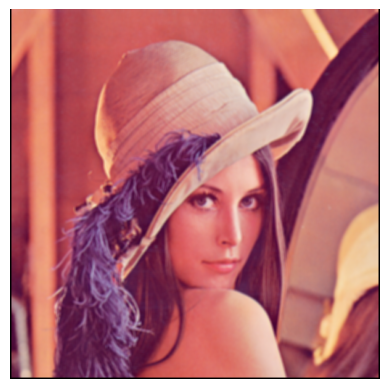

In [21]:
def average(P_in:np.ndarray,n=4):
    padding = n // 2
    img = np.zeros((P_in.shape[0]-padding,P_in.shape[1]-padding,P_in.shape[2]))
    for i in range(P_in.shape[0]-padding * 2):
        for j in range(padding, P_in.shape[1] - padding * 2):
            for c in range(3):
                sm = 0
                for k in range(n):
                    for l in range(n):
                        # print(sm)
                        sm += P_in[i+k,j+l,c].astype(np.int32)
                img[i,j,c] = sm / n**2
    img = 1/np.max(img)*img
    print(img.shape)
    return img
plt.imshow(average(bgr_image))
plt.axis("off")

In [27]:
def average(P_in: np.ndarray, n=3):
    # Create a kernel for averaging
    kernel = np.ones((n, n, 1), dtype=np.float32)# / (n ** 2)
    
    img = np.zeros_like(P_in, dtype=np.float32)
    
    for c in range(P_in.shape[2]):
        img[..., c] = np.convolve(P_in[..., c].flatten(), kernel[..., 0].flatten(), mode='same').reshape(P_in.shape[0], P_in.shape[1])
    img = img / np.max(img)
    
    # print(img.shape)
    return img


In [ ]:
@interact(x=widgets.IntSlider(
    min=1,
    max=20,
    step=1,
    value=1
))
def blur(x):
    plt.imshow(average(bgr_image, n=x))
    plt.axis("off")

interactive(children=(IntSlider(value=1, description='x', max=20, min=1), Output()), _dom_classes=('widget-int…